# Environment Setup

In [1]:
import time
from itertools import combinations
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import yfinance as yf
from curl_cffi import requests

# Suppress all warnings
warnings.filterwarnings("ignore")

# Setup session
session = requests.Session(impersonate="chrome")

# Tickers
tickers = ["SPY", "QQQ", "VTI", "EFA", "TLT", "SHY", "TIP"]

# Load price data
#data = yf.download(tickers, start="2001-01-01", end="2025-10-30", session=session)["Close"]
#data.to_csv("data.csv")
data = pd.read_csv("data.csv")
data = data.set_index('Date')

# Inspect dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6241 entries, 2001-01-02 to 2025-10-24
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EFA     6077 non-null   float64
 1   QQQ     6241 non-null   float64
 2   SHY     5849 non-null   float64
 3   SPY     6241 non-null   float64
 4   TIP     5507 non-null   float64
 5   TLT     5849 non-null   float64
 6   VTI     6127 non-null   float64
dtypes: float64(7)
memory usage: 390.1+ KB


# Portfolio Optimisation using Monte Carlo

In [2]:
# -----------------------------
# 1. Setup returns and dates
# -----------------------------
start_time = time.time()

data.index = pd.to_datetime(data.index)
returns = data.pct_change().dropna()
returns_array = returns.values
rf_rate = 0.04  # risk-free rate
dates = returns.index

# Quarterly boundaries for rebalancing
quarter_ends = returns.resample("QE").apply(lambda x: x.index[-1]).index.values
quarter_indices = np.searchsorted(dates.values, quarter_ends)


# -----------------------------
# 2. Prepare tracking variables
# -----------------------------
best_sharpe = -np.inf
best_subset = None
best_weights = None
best_results = None

all_portfolios = []  # store all portfolio info for plotting


# -----------------------------
# 3. Monte Carlo simulation over all ticker subsets
# -----------------------------
for r in range(1, len(tickers)+1):
    for subset in combinations(range(len(tickers)), r):
        subset_returns = returns_array[:, subset]
        n_assets = subset_returns.shape[1]

        num_portfolios = 1_000  # Monte Carlo portfolios per subset
        for _ in range(num_portfolios):
            # Random weights
            weights = np.random.random(n_assets)
            weights /= np.sum(weights)

            # Initialize portfolio series
            portfolio_value = 1.0
            portfolio_series = []

            # Quarterly rebalancing
            start_idx = 0
            for q_end in quarter_indices:
                chunk_returns = subset_returns[start_idx:q_end + 1]
                daily_growth = 1 + chunk_returns @ weights
                cumulative = portfolio_value * np.cumprod(daily_growth)
                portfolio_series.extend(cumulative)
                portfolio_value = cumulative[-1]
                start_idx = q_end + 1

            portfolio_series = np.array(portfolio_series)

            # Portfolio metrics
            total_days = len(portfolio_series)
            total_return = portfolio_series[-1] / portfolio_series[0] - 1
            annualized_return = (1 + total_return) ** (252 / total_days) - 1
            vol = np.std(np.diff(np.log(portfolio_series))) * np.sqrt(252)
            sharpe = (annualized_return - rf_rate) / vol

            # Store portfolio info
            all_portfolios.append({
                "subset": [tickers[i] for i in subset],
                "weights": weights,
                "annualized_return": annualized_return,
                "volatility": vol,
                "sharpe": sharpe,
                "series": np.array(portfolio_series)
            })

            # Track best Sharpe
            if sharpe > best_sharpe:
                best_sharpe = sharpe
                best_subset = subset
                best_weights = weights
                best_results = (annualized_return, vol, sharpe)


# -----------------------------
# 4. Wrap up and convert to DataFrame
# -----------------------------
end_time = time.time()
print(f"Monte Carlo with {2**len(tickers)} subsets completed in {end_time - start_time:.2f} seconds")

all_portfolios_df = pd.DataFrame(all_portfolios)

Monte Carlo with 128 subsets completed in 86.14 seconds


# Efficient Frontier Visualisation

Optimal Portfolio Weights (Quarterly Rebalanced Subset):
QQQ: 63.10%
SHY: 36.90%

Expected Annualized Return: 11.69%
Volatility: 13.25%
Sharpe Ratio: 0.580


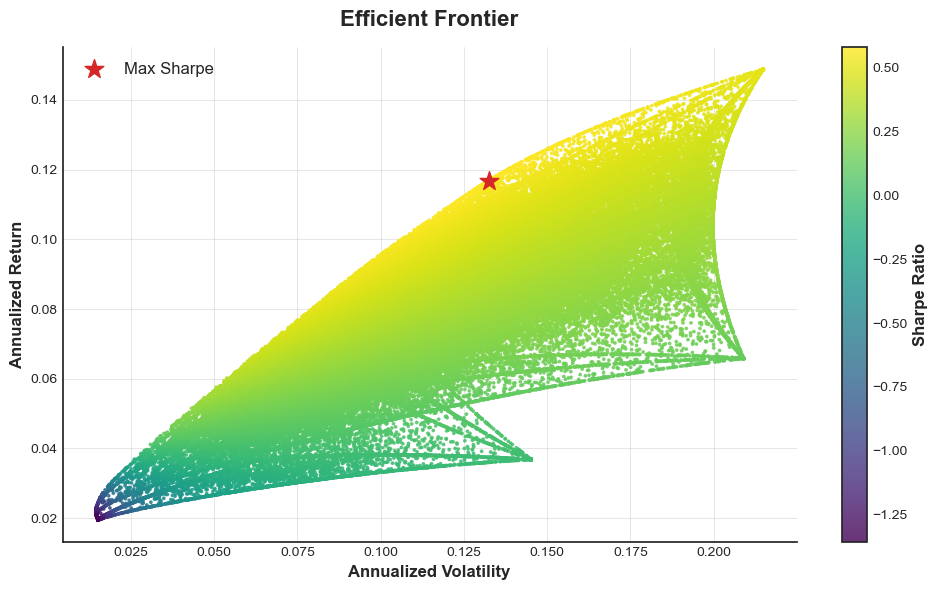

In [3]:
# -----------------------------
# 1. Map best subset indices to tickers
# -----------------------------
best_tickers = [tickers[i] for i in best_subset]

print("Optimal Portfolio Weights (Quarterly Rebalanced Subset):")
for t, w in zip(best_tickers, best_weights):
    print(f"{t}: {w:.2%}")

print(f"\nExpected Annualized Return: {best_results[0]:.2%}")
print(f"Volatility: {best_results[1]:.2%}")
print(f"Sharpe Ratio: {best_results[2]:.3f}")


# -----------------------------
# 2. Efficient Frontier Plot
# -----------------------------
plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(10,6))

# Scatter all portfolios colored by Sharpe
scatter = plt.scatter(
    all_portfolios_df["volatility"], 
    all_portfolios_df["annualized_return"],
    c=all_portfolios_df["sharpe"], 
    cmap="viridis", 
    s=3,        # point size
    alpha=0.8    # subtle transparency
)

# Colorbar for Sharpe ratio
cbar = plt.colorbar(scatter)
cbar.set_label("Sharpe Ratio", fontsize=12, weight='bold')

# Highlight max Sharpe portfolio
plt.scatter(
    best_results[1], best_results[0], 
    color="#D62728",  # professional red
    s=200, 
    marker='*', 
    label='Max Sharpe'
)

# Axis labels and title
plt.xlabel("Annualized Volatility", fontsize=12, weight='bold')
plt.ylabel("Annualized Return", fontsize=12, weight='bold')
plt.title("Efficient Frontier", fontsize=16, weight='bold', pad=15)

# Legend
plt.legend(frameon=False, fontsize=12)

# Gridlines and remove spines
plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.7)
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

# Ticks formatting
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.savefig('eff_fr.png', dpi=300)

plt.tight_layout()
plt.show()

# Optimal Portfolio vs SPY (S&P500 ETF)

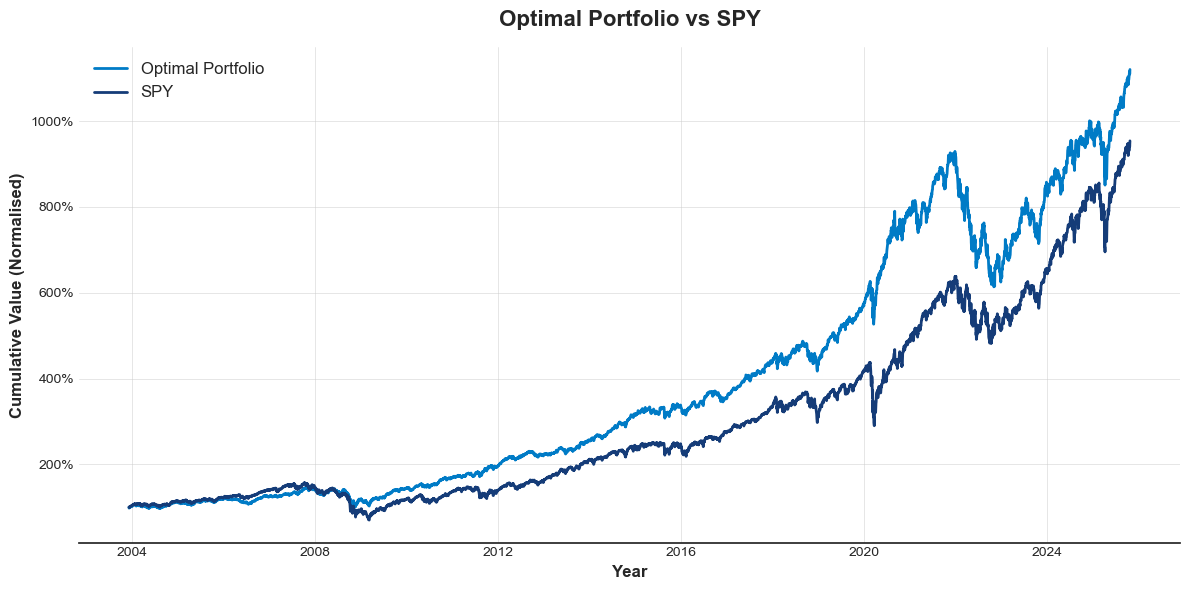

,Return (Annualized),Volatility (Annualized),Sharpe Ratio
Optimal Portfolio,0.116876,0.132490,0.580240
SPY,0.108403,0.188032,0.363783


In [4]:
# -----------------------------
# 1. Define metrics computation function
# -----------------------------
def compute_metrics(series, rf_rate=0.04):
    total_days = len(series)
    total_return = series[-1] / series[0] - 1
    annualized_return = (1 + total_return) ** (252 / total_days) - 1
    vol = np.std(np.diff(np.log(series))) * np.sqrt(252)
    sharpe = (annualized_return - rf_rate) / vol
    return annualized_return, vol, sharpe


# -----------------------------
# 2. Extract best portfolio series
# -----------------------------
for p in all_portfolios:
    if len(p['weights']) == len(best_weights) and np.allclose(p['weights'], best_weights) and p['subset'] == best_tickers:
        best_portfolio_series = p['series']
        break

portfolio_series = pd.Series(best_portfolio_series, index=returns.index[:len(best_portfolio_series)])
spy_series = (1 + returns['SPY']).cumprod()


# -----------------------------
# 3. Compute metrics
# -----------------------------
rf_rate = 0.04
portfolio_annualized_return, portfolio_vol, portfolio_sharpe = compute_metrics(portfolio_series, rf_rate)
spy_annualized_return, spy_vol, spy_sharpe = compute_metrics(spy_series, rf_rate)


# -----------------------------
# 4. Plot cumulative portfolio vs SPY
# -----------------------------
plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(12,6))

plt.plot(portfolio_series, label="Optimal Portfolio", color="#007BC6", linewidth=2)
plt.plot(spy_series, label="SPY", color="#153C78", linewidth=2)

plt.xlabel("Year", fontsize=12, weight='bold')
plt.ylabel("Cumulative Value (Normalised)", fontsize=12, weight='bold')
plt.title("Optimal Portfolio vs SPY", fontsize=16, weight='bold', pad=15)

plt.legend(frameon=False, fontsize=12)

plt.grid(True, which='major', linestyle='-', linewidth=0.5, alpha=0.7)
for spine in ["top","right","left"]:
    plt.gca().spines[spine].set_visible(False)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout()
plt.show()


# -----------------------------
# 5. Create and display metrics DataFrame
# -----------------------------
metrics_df = pd.DataFrame({
    "Return (Annualized)": [portfolio_annualized_return, spy_annualized_return],
    "Volatility (Annualized)": [portfolio_vol, spy_vol],
    "Sharpe Ratio": [portfolio_sharpe, spy_sharpe]
}, index=["Optimal Portfolio", "SPY"])

display(metrics_df)

# Rolling-Window Monte Carlo

In [5]:
# -----------------------------
# 0. Parameters
# -----------------------------
rf_rate = 0.04
window_size = 252 * 10  # 10-year rolling window
step_size = 252         # 1-year step
num_portfolios = 1_000  # Monte Carlo portfolios per subset

start_time = time.time()


# -----------------------------
# 1. Prepare returns and rolling containers
# -----------------------------
data.index = pd.to_datetime(data.index)
returns = data.pct_change().dropna()

tickers = returns.columns.tolist()
rolling_portfolio_series = pd.Series(index=returns.index, dtype=float)
rolling_weights = []

dates = returns.index


# -----------------------------
# 2. Rolling window simulation
# -----------------------------
for start in range(0, len(returns) - window_size, step_size):
    end = start + window_size
    train_returns = returns.iloc[start:end]
    test_returns = returns.iloc[end:end+step_size]  # out-of-sample
    
    if test_returns.empty:
        break
    
    # --- Find best subset/weights on TRAIN window ---
    best_sharpe = -np.inf
    best_subset = None
    best_weights = None
    
    for r in range(1, len(tickers)+1):
        for subset in combinations(range(len(tickers)), r):
            subset_train = train_returns.iloc[:, list(subset)].values
            n_assets = subset_train.shape[1]
            
            for _ in range(num_portfolios):
                weights = np.random.random(n_assets)
                weights /= np.sum(weights)
                
                # Portfolio metrics on TRAIN
                mean_returns = subset_train.mean(axis=0)
                port_ret = np.sum(weights * mean_returns) * 252
                cov_matrix = np.cov(subset_train.T) * 252
                cov_matrix = np.atleast_2d(cov_matrix)
                port_vol = np.sqrt(weights @ cov_matrix @ weights)
                sharpe = (port_ret - rf_rate) / port_vol
                
                if sharpe > best_sharpe:
                    best_sharpe = sharpe
                    best_subset = subset
                    best_weights = weights
    
    # --- Apply best weights to TEST period ---
    subset_test = test_returns.iloc[:, list(best_subset)].values
    daily_growth = 1 + subset_test @ best_weights
    cumulative_growth = pd.Series(daily_growth).cumprod()
    
    # Stitch into rolling portfolio series
    if rolling_portfolio_series.dropna().empty:
        rolling_portfolio_series.loc[test_returns.index] = cumulative_growth.values
    else:
        last_val = rolling_portfolio_series.dropna().iloc[-1]
        rolling_portfolio_series.loc[test_returns.index] = last_val * cumulative_growth.values
    
    # Store rolling window weights
    rolling_weights.append({
        "start": returns.index[start],
        "end": returns.index[end],
        "subset": [tickers[i] for i in best_subset],
        "weights": best_weights,
        "sharpe": best_sharpe
    })


# -----------------------------
# 3. Wrap up
# -----------------------------
end_time = time.time()
print(f"Rolling Monte Carlo completed in {end_time - start_time:.2f} seconds")

# Convert rolling weights to DataFrame for display/analysis
rolling_weights_df = pd.DataFrame(rolling_weights)
display(rolling_weights_df)

Rolling Monte Carlo completed in 125.88 seconds


,start,end,subset,weights,sharpe
0,2003-12-08,2013-12-11,"[QQQ, TLT]","[0.4593175709339199, 0.5406824290660801]",0.532401
1,2004-12-08,2014-12-11,"[QQQ, TLT]","[0.4315017247634528, 0.5684982752365472]",0.653218
2,2005-12-07,2015-12-11,"[QQQ, TLT]","[0.45793128246543935, 0.5420687175345605]",0.630184
3,2006-12-07,2016-12-12,"[QQQ, TLT]","[0.48307217942347297, 0.516927820576527]",0.597940
4,2007-12-10,2017-12-12,"[QQQ, TLT]","[0.48811451002407613, 0.5118854899759239]",0.675679
5,2008-12-09,2018-12-13,"[QQQ, TLT]","[0.6447358527540529, 0.3552641472459472]",0.956685
6,2009-12-09,2019-12-13,"[QQQ, TLT]","[0.5506771094060955, 0.44932289059390457]",1.049046
7,2010-12-09,2020-12-14,"[QQQ, TLT]","[0.5130722299343389, 0.4869277700656612]",1.096988
8,2011-12-08,2021-12-14,"[QQQ, TLT]","[0.6227201363591879, 0.3772798636408121]",1.052385
9,2012-12-11,2022-12-14,[QQQ],[1.0],0.668135


# Median Portfolio vs SPY

Median Portfolio Weights (normalized):


QQQ    0.531875
TLT    0.468125
EFA    0.000000
SHY    0.000000
SPY    0.000000
TIP    0.000000
VTI    0.000000
dtype: float64


Performance of Median-Weight Portfolio (20 years):
Annualized Return: 10.76%
Volatility:        11.86%
Sharpe Ratio:      0.57

Performance of SPY (20 years):
Annualized Return: 11.11%
Volatility:        19.38%
Sharpe Ratio:      0.37


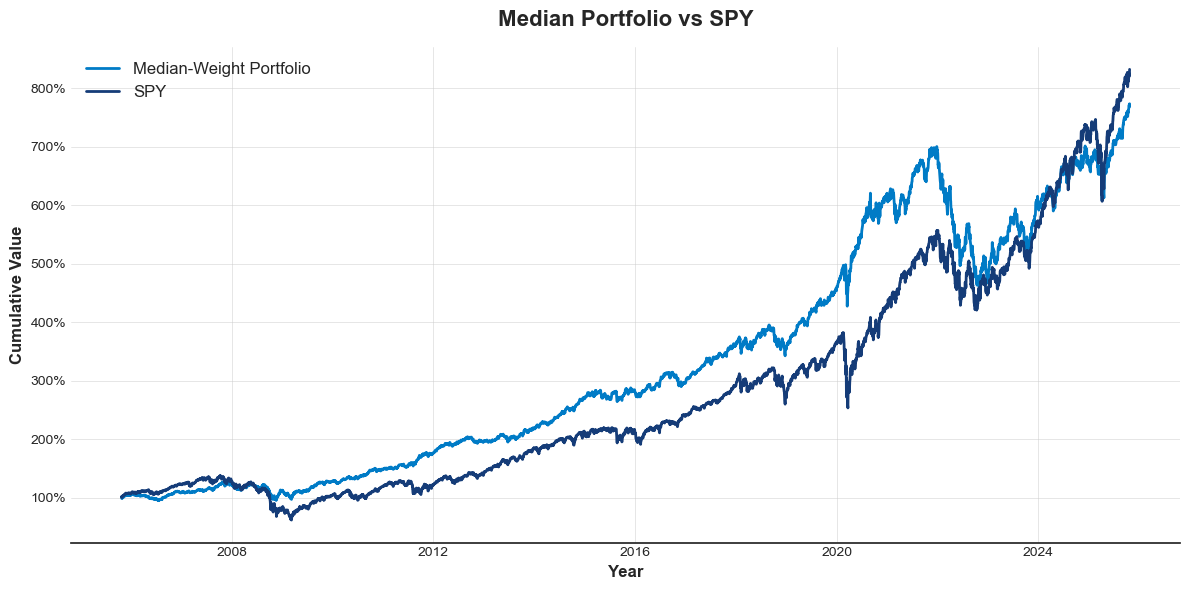

In [6]:
# -----------------------------
# 1. Convert rolling window weights into full ticker vectors
# -----------------------------
rows = []
for rw in rolling_weights:
    row = pd.Series(0.0, index=tickers)
    for asset, w in zip(rw['subset'], rw['weights']):
        row[asset] = w
    rows.append(row)

weights_df = pd.DataFrame(rows)


# -----------------------------
# 2. Compute median portfolio weights across windows
# -----------------------------
median_weights = weights_df.median(axis=0)
median_weights /= median_weights.sum()  # normalize to sum = 1

print("Median Portfolio Weights (normalized):")
display(median_weights.sort_values(ascending=False))


# -----------------------------
# 3. Apply median portfolio to full return series
# -----------------------------
start_date = "2005-10-24"
end_date   = "2025-10-24"

# Filter available tickers and slice date range
available_tickers = median_weights.index.intersection(returns.columns)
median_weights = median_weights[available_tickers]
portfolio_returns = returns[available_tickers].loc[start_date:end_date]
spy_returns = returns['SPY'].loc[start_date:end_date]

# Normalize weights
median_weights = median_weights / median_weights.sum()

# Identify quarter-end dates
quarter_ends = portfolio_returns.resample("QE").apply(lambda x: x.index[-1]).index
if quarter_ends[-1] < portfolio_returns.index[-1]:
    quarter_ends = quarter_ends.append(pd.Index([portfolio_returns.index[-1]]))

# Initialize portfolio
portfolio_value = 1.0
weights = median_weights.values
portfolio_series = []
current_values = portfolio_value * weights

# Simulate daily returns with quarterly rebalancing
for date in portfolio_returns.index:
    daily_ret = portfolio_returns.loc[date].values
    current_values *= (1 + daily_ret)
    portfolio_value = np.sum(current_values)
    portfolio_series.append(portfolio_value)
    
    # Rebalance at quarter end
    if date in quarter_ends:
        current_values = portfolio_value * weights  # reset positions

# Construct cumulative series
cumulative_portfolio = pd.Series(portfolio_series, index=portfolio_returns.index)
cumulative_spy = (1 + spy_returns).cumprod()



# -----------------------------
# 4. Performance metrics function
# -----------------------------
def performance_metrics(cumulative, rf_rate=rf_rate):
    total_days = len(cumulative)
    total_return = cumulative.iloc[-1] / cumulative.iloc[0] - 1
    annualized_return = (1 + total_return) ** (252 / total_days) - 1
    vol = np.std(np.diff(np.log(cumulative))) * np.sqrt(252)
    sharpe = (annualized_return - rf_rate) / vol
    return annualized_return, vol, sharpe


# -----------------------------
# 5. Compute metrics
# -----------------------------
port_ann, port_vol, port_sharpe = performance_metrics(cumulative_portfolio)
spy_ann, spy_vol, spy_sharpe = performance_metrics(cumulative_spy)


# -----------------------------
# 6. Print performance metrics
# -----------------------------
print("\nPerformance of Median-Weight Portfolio (20 years):")
print(f"Annualized Return: {port_ann:.2%}")
print(f"Volatility:        {port_vol:.2%}")
print(f"Sharpe Ratio:      {port_sharpe:.2f}")

print("\nPerformance of SPY (20 years):")
print(f"Annualized Return: {spy_ann:.2%}")
print(f"Volatility:        {spy_vol:.2%}")
print(f"Sharpe Ratio:      {spy_sharpe:.2f}")


# -----------------------------
# 7. Plot cumulative growth
# -----------------------------
plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(12,6))

plt.plot(cumulative_portfolio, label="Median-Weight Portfolio", color="#007BC6", linewidth=2)
plt.plot(cumulative_spy, label="SPY", color="#153C78", linewidth=2)

plt.xlabel("Year", fontsize=12, weight='bold')
plt.ylabel("Cumulative Value", fontsize=12, weight='bold')
plt.title("Median Portfolio vs SPY", fontsize=16, weight='bold', pad=15)

plt.legend(frameon=False, fontsize=12)

plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.7)
for spine in ["top","right","left"]:
    plt.gca().spines[spine].set_visible(False)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # normalize

plt.tight_layout()

plt.savefig('med_pf.png', dpi=300)

plt.show()